# 11: L2 Regularization (Weight Decay)

### 🎯 Objective
This notebook demonstrates how to implement **L2 Regularization** in PyTorch. We will use the Iris dataset again but train a model with a specific constraint: we want to keep the model's weights small to prevent overfitting.

### 📚 Key Concepts
- **L2 Regularization:** Adding a penalty term to the loss function proportional to the square of the weights: $\lambda \sum w^2$.
- **Weight Decay:** The implementation name for L2 regularization in optimizers (like SGD or Adam).
- **The Trade-off:** Increasing $\lambda$ reduces overfitting (variance) but can increase underfitting (bias) if set too high.

In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# load the dataloader
from torch.utils.data import DataLoader

## 1. Prepare Data (Iris Dataset)
Standard data loading and preprocessing.

In [2]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

In [3]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

## 2. Create DataLoaders
We split the data 80/20 and wrap it into PyTorch DataLoaders for batching.

In [4]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# create dataloader objects
# batch_size=64: We update weights after every 64 samples
# drop_last=True: If the dataset size isn't divisible by 64, drop the final smaller batch
train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

## 3. Create Model with L2 Regularization

This is the key part. L2 regularization is **NOT** defined in the model architecture (like Dropout). It is defined in the **Optimizer**.

**Look at this line:**
`optimizer = torch.optim.SGD(..., weight_decay=L2lambda)`

The `weight_decay` parameter sets the strength ($\\lambda$) of the L2 penalty.

In [5]:
# a function that creates the ANN model

def createANewModel(L2lambda):

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  # weight_decay is the PyTorch implementation of L2 regularization
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.005,weight_decay=L2lambda)

  return ANNiris,lossfun,optimizer

## 4. Train the Model
Standard training loop with mini-batches. We track losses and accuracy.

In [6]:
# train the model

# global parameter
numepochs = 1000

def trainTheModel():

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    ANNiris.eval() # Switch to eval mode (though L2 works in both modes, standard practice)
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

    # Reset to train mode
    ANNiris.train()

  # function output
  return trainAcc,testAcc,losses


## 5. Test Run (Single Lambda)
We test the code with a small L2 penalty (`L2lambda = 0.01`) to ensure everything works.

In [7]:
# create a model
L2lambda = .01
ANNiris,lossfun,optimizer = createANewModel(L2lambda)

# train the model
trainAcc,testAcc,losses = trainTheModel()


<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-1941010148.py:8: SyntaxWarning: invalid escape sequence '\l'
  ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))
/tmp/ipython-input-1941010148.py:12: SyntaxWarning: invalid escape sequence '\l'
  ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))


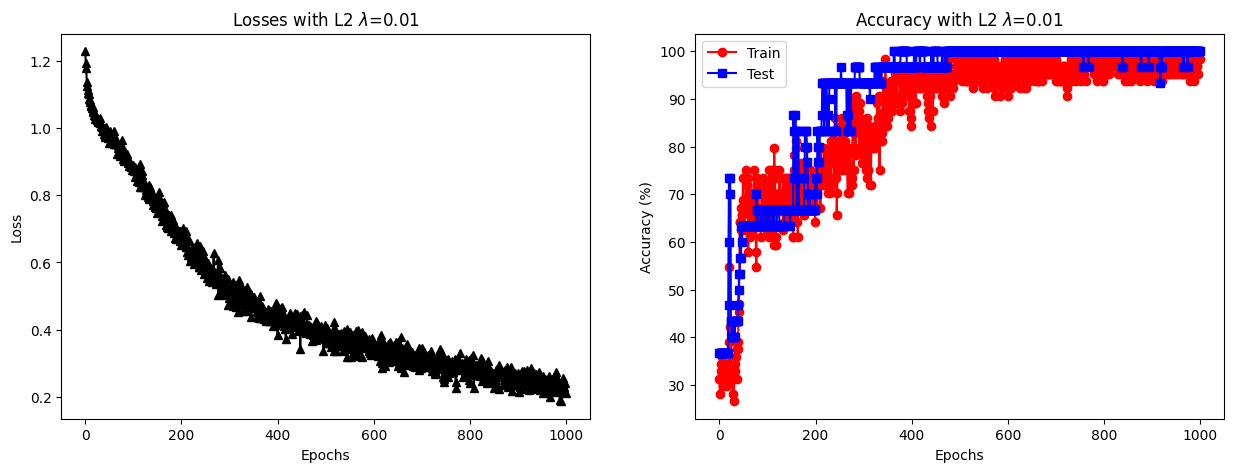

In [8]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [9]:
# create a 1D smoothing filter
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k,mode='same')

## 6. The Experiment: Varying L2 Strength

We will test varying values of $\lambda$ (from 0.0 to 0.1). 

**Prediction:**
* **Low $\lambda$:** Similar to standard training.
* **High $\lambda$:** The model will be penalized too heavily for learning patterns, leading to **underfitting** (both train and test accuracy will drop).

In [10]:
# range of L2 regularization amounts
l2lambdas = np.linspace(0,.1,10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(l2lambdas)))
accuracyResultsTest  = np.zeros((numepochs,len(l2lambdas)))


# loop over different lambda values
for li in range(len(l2lambdas)):

  # create and train a model
  ANNiris,lossfun,optimizer = createANewModel(l2lambdas[li])
  trainAcc,testAcc,losses = trainTheModel()

  # store data (smoothed for easier visualization)
  accuracyResultsTrain[:,li] = smooth(trainAcc,10)
  accuracyResultsTest[:,li]  = smooth(testAcc,10)

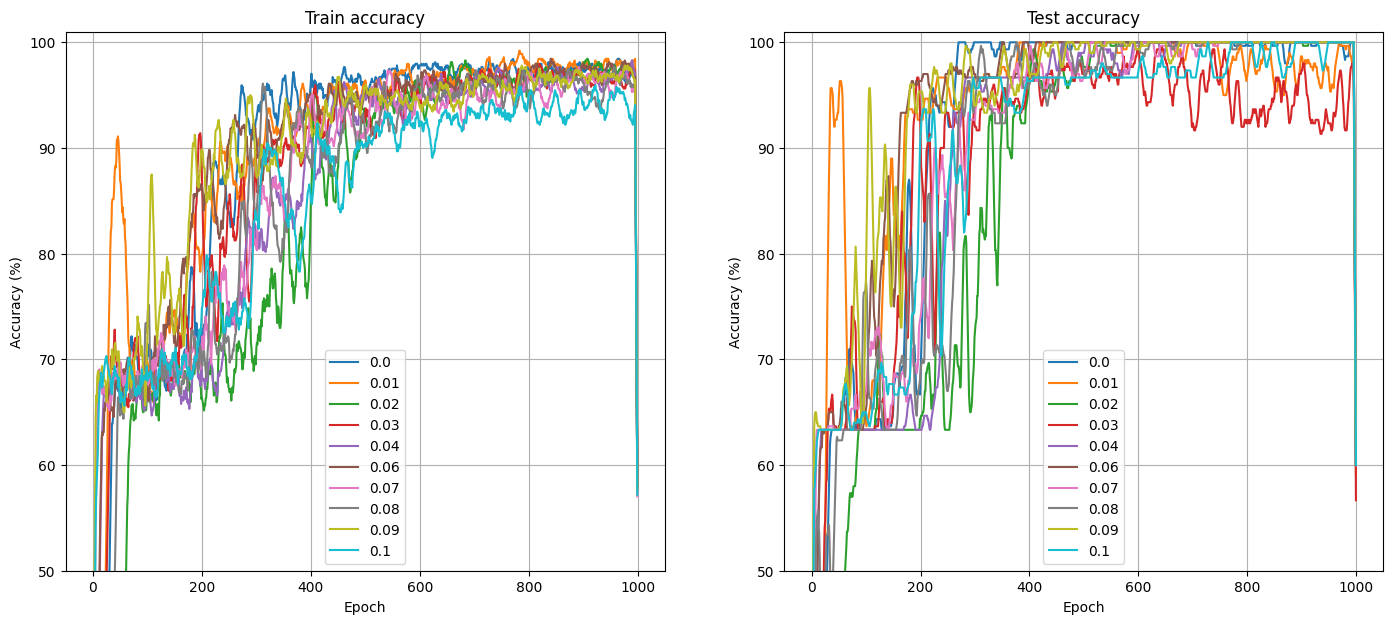

In [11]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,2) for i in l2lambdas]

# common features
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

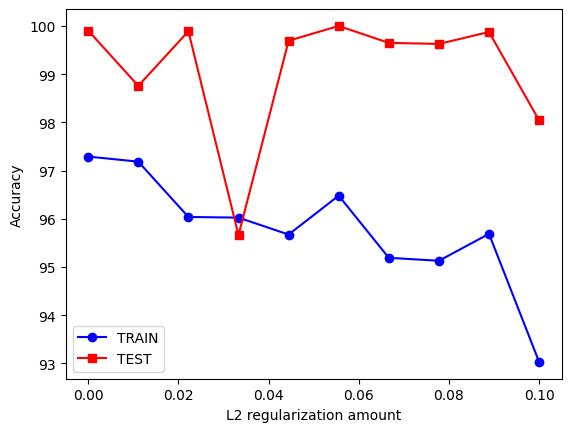

In [ ]:
# show average accuracy by L2 rate

# We average only the final epochs (500-950) to see the converged performance
epoch_range = [500,950]


plt.plot(l2lambdas,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(l2lambdas,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
